# Imports

In [78]:
import pandas as pd; import seaborn as sb; import statsmodels.formula.api as smf; import pingouin;
from itertools import combinations; import os; from analysis_helpers import *; 
import scipy; from scipy import stats; import os; import math; import warnings
warnings.filterwarnings('ignore')

# Load and organize data

In [79]:
gaze       = pd.read_csv('../parsed_data/full_gaze.csv')
behavioral = pd.read_csv('../parsed_data/full_behavioral.csv')

In [80]:
behavioral.loc[behavioral['Trial Type']=='Presentation','Cued Face'] = behavioral[behavioral['Trial Type']=='Presentation']['Cued Composite'].str.split('_',n=1, expand=True)[0]
behavioral.loc[behavioral['Trial Type']=='Presentation','Cued Place'] = behavioral[behavioral['Trial Type']=='Presentation']['Cued Composite'].str.split('_',n=1, expand=True)[1]
behavioral.loc[behavioral['Trial Type']=='Presentation','Uncued Face'] = behavioral[behavioral['Trial Type']=='Presentation']['Uncued Composite'].str.split('_',n=1, expand=True)[0]
behavioral.loc[behavioral['Trial Type']=='Presentation','Uncued Place'] = behavioral[behavioral['Trial Type']=='Presentation']['Uncued Composite'].str.split('_',n=1, expand=True)[1]

In [81]:
behavioral.loc[behavioral['Trial Type']=='Presentation','Cued Face'] = behavioral[behavioral['Trial Type']=='Presentation']['Cued Face']+'.jpg'

In [82]:
behavioral.loc[behavioral['Trial Type']=='Presentation','Uncued Face'] = behavioral[behavioral['Trial Type']=='Presentation']['Uncued Face']+'.jpg'

In [83]:
gaze.head(n=2)

,Unnamed: 0,Unnamed: 0.1,avg,fix,lefteye,raw,righteye,state,time,timestamp,...,xRaw_lefteye,yRaw_lefteye,av_x_coord,av_y_coord,Subject,UniqueID,Group,Experiment,Trial,Run
0,0,43696,"{'x': 1041.042, 'y': 501.128}",True,"{'avg': {'x': 989.74, 'y': 494.5082}, 'pcenter...","{'x': 1029.6586, 'y': 493.4627}","{'avg': {'x': 1092.8706, 'y': 545.1093}, 'pcen...",7,994163077,1.538592e+09,...,989.0439,458.6258,1029.65855,493.4627,10,0,1,/sustain,0.0,3
1,1,43697,"{'x': 1039.5768, 'y': 503.2538}",True,"{'avg': {'x': 989.9557, 'y': 494.9846}, 'pcent...","{'x': 1040.4014, 'y': 537.1355}","{'avg': {'x': 1092.2872, 'y': 546.3817}, 'pcen...",7,994163112,1.538592e+09,...,993.0250,508.4023,1040.40140,537.1355,10,0,1,/sustain,0.0,3


In [84]:
behavioral.head(n=2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,...,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Attention Probe,Trial,UniqueID,Group,Experiment
0,0,0,150,10,Presentation,3,00926960627Fa_sunapqwoeotxshkukbh.jpg,00076931230fa_sunaafewhewbxmjiurz.jpg,00926960627Fa.jpg,sunapqwoeotxshkukbh.jpg,...,NaN,1.0,NaN,1.538592e+09,1.538592e+09,x,0.0,0,1,/sustain
1,1,1,151,10,Presentation,3,00725941201fa_sunaefgzwiramypjvtd.jpg,00828940307fa_sunahuynahneraqftyz.jpg,00725941201fa.jpg,sunaefgzwiramypjvtd.jpg,...,NaN,3.0,NaN,1.538592e+09,1.538592e+09,o,1.0,0,1,/sustain


# Tendency to gaze towards cued side

In [85]:
# behavioral[(behavioral['av_x_coord'].isnull()) 
#           &(behavioral['Trial Type'] == 'Presentation') 
#           & (behavioral['Group'] != 2)]

In [86]:
gaze['av_x_coord'] = (59.8/2048)*(gaze[['xRaw_righteye', 'xRaw_lefteye']].mean(axis=1))
gaze['av_y_coord'] = (33.6/1152)*(gaze[['yRaw_righteye', 'yRaw_lefteye']].mean(axis=1))

In [87]:
gaze = gaze[(gaze['av_x_coord']   < 59.8) 
                                  & (gaze['av_y_coord'] < 33.6)
                                  & (gaze['av_x_coord'] > 0)
                                  & (gaze['av_y_coord'] > 0)]

In [88]:
# group gaze data by participant, run #, and trial #
# add average x coordinate from gaze data
gaze_grp = gaze.groupby(['UniqueID', 'Run', 'Trial'], as_index=False).mean()

# sort both dataframes
gaze_grp   = gaze_grp.sort_values(by=['UniqueID','Run','Trial'])
behavioral = behavioral.sort_values(by=['UniqueID','Run','Trial'])

for idx,x in gaze_grp.iterrows():
    behavioral.loc[(behavioral['UniqueID']==x['UniqueID']) 
                   & (behavioral['Run']==x['Run']) 
                   & (behavioral['Trial']==x['Trial'])
                   & (behavioral['Trial Type']=='Presentation'), 'av_x_coord'] = x['av_x_coord']

In [89]:
# compute av x gaze's difference from screen center
behavioral['gaze_from_center'] = behavioral['av_x_coord'] - 59.8/2

# make the difference value negative for opposite facing arrow
behavioral['gaze_towards_cued_side'] = behavioral['gaze_from_center']
behavioral.loc[(behavioral['Cued Side']=='<'),'gaze_towards_cued_side'] = -behavioral.loc[(behavioral['Cued Side']=='<')]['gaze_towards_cued_side']

In [90]:
def add_gaze(df):

    '''
    input: df containing pres and mem from single run
    output: df with string in 'Attention Level' column in each Memory trial row
    '''

    for index,row in df.iterrows():
        if row['Trial Type']=='Memory':
            mem_image = row['Memory Image']
            for cue in ['Cued ', 'Uncued ']:
                for cat in ['Face', 'Place']:
                    if df.loc[df[cue+cat] == mem_image].shape[0]!=0:
                        df['gaze_towards_cued_side'][index]=df.loc[df[cue+cat] == mem_image]['gaze_towards_cued_side']
                        df['Cued Side'][index] = df.loc[df[cue+cat] == mem_image]['Cued Side'].item()

    mem_mask = df['Trial Type']=='Memory'
    df.loc[mem_mask,'gaze_towards_cued_side'] = df.loc[mem_mask,'gaze_towards_cued_side'].fillna(np.nan)

    return(df)

In [91]:
behavioral_added = behavioral
for subject in behavioral['UniqueID'].unique():
    behavioral_added[behavioral_added ['UniqueID']==subject] = add_gaze(behavioral_added [behavioral_added ['UniqueID']==subject])
        

In [92]:
behavioral_added[behavioral_added['Trial Type']=='Memory'][['Attention Level','gaze_towards_cued_side']]

,Attention Level,gaze_towards_cued_side
80,Novel,NaN
81,Category,-1.828081
82,Novel,NaN
83,Full,-3.060598
84,Side,-2.398763
...,...,...
44395,Full,-0.231648
44396,Novel,NaN
44397,Side,0.826920
44398,Novel,NaN


In [93]:
behavioral_added['gaze_towards_mem_image'] = behavioral_added['gaze_towards_cued_side']
behavioral_added.loc[behavioral_added['Attention Level']=='None','gaze_towards_mem_image'] = -behavioral_added[behavioral_added['Attention Level']=='None']['gaze_towards_mem_image'] 
behavioral_added.loc[behavioral_added['Attention Level']=='Category','gaze_towards_mem_image'] = -behavioral_added[behavioral_added['Attention Level']=='Category']['gaze_towards_mem_image'] 

In [94]:
behavioral_added['gaze_towards_mem_image'] = behavioral_added['gaze_towards_mem_image']/(59.8/2)

/variabl
1


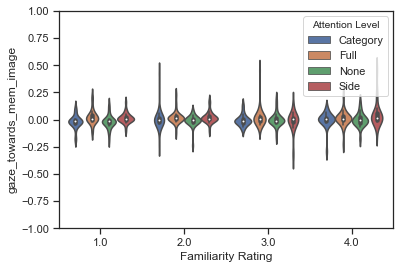


/variabl
2


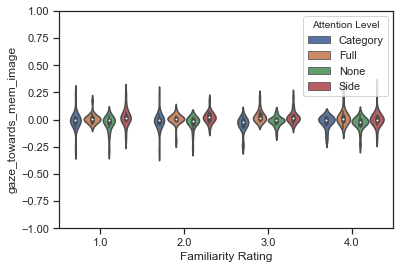


/sustain
1


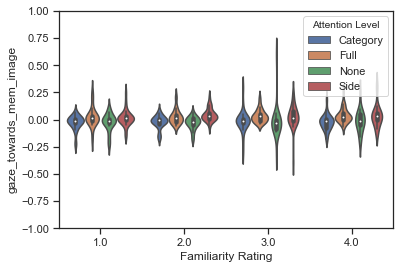


/sustain
2


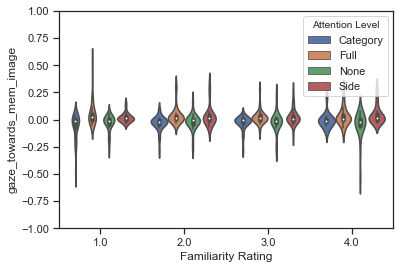

In [95]:
for exp in ['/variabl','/sustain']:

    for group in [1,2]:
        
        print(exp)
        print(group)
        
        data = behavioral_added[(behavioral_added['Experiment']==exp) 
                                & (behavioral_added['Group']==group)].groupby(['UniqueID','Attention Level','Familiarity Rating'],as_index=False).mean()
        
        sb.violinplot(x='Familiarity Rating', y='gaze_towards_mem_image', hue='Attention Level', 
                      data=data[data['Attention Level'] != 'Novel'])
        
        plt.ylim(-1, 1)
        plt.show()
        
        print()

# --------

In [ ]:
# make the difference value negative for opposite facing arrow
behavioral['gaze_towards_cued_side'] = behavioral['gaze_from_center']
behavioral.loc[(behavioral['Cued Side']=='<'),'gaze_towards_cued_side'] = -behavioral.loc[(behavioral['Cued Side']=='<')]['gaze_towards_cued_side']

In [85]:
# ttest relative to zero drift! 
behav_grp = behavioral.groupby(['Experiment','Group', 'UniqueID'], as_index=False).mean()

for exp in ['/sustain','/variabl']:
    for group in [1,2]:
        
        print(exp)
        print(group)
        print(scipy.stats.ttest_1samp(behav_grp[(behav_grp['Experiment']==exp)
                                               &(behav_grp['Group']==group)]['gaze_towards_cued_side'],0))
        
        print(np.mean(behav_grp[(behav_grp['Experiment']==exp)&(behav_grp['Group']==group)]['gaze_towards_cued_side'])/np.std(behav_grp[(behav_grp['Experiment']==exp)
                                               &(behav_grp['Group']==group)]['gaze_towards_cued_side']))
        print()

/sustain
1
Ttest_1sampResult(statistic=-0.9614645100948709, pvalue=0.3442673788020433)
-0.17853947734730055

/sustain
2
Ttest_1sampResult(statistic=2.810057260358112, pvalue=0.008781162844675176)
0.5218145332590796

/variabl
1
Ttest_1sampResult(statistic=1.9383858536441954, pvalue=0.06236520390190898)
0.35994921661007223

/variabl
2
Ttest_1sampResult(statistic=2.094529830443702, pvalue=0.04915216915601463)
0.4683511081773227



# Data restricted to gaze between images

In [86]:
gaze.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'avg', 'fix', 'lefteye', 'raw',
       'righteye', 'state', 'time', 'timestamp', 'xRaw_righteye',
       'yRaw_righteye', 'xRaw_lefteye', 'yRaw_lefteye', 'av_x_coord',
       'av_y_coord', 'Subject', 'UniqueID', 'Group', 'Experiment', 'Trial',
       'Run'],
      dtype='object')

In [89]:
gaze_restricted = behavioral[abs(behavioral['gaze_from_center'])<4.2752]
gaze_restricted = gaze_restricted.groupby(['UniqueID','Run','Trial'], as_index=False).mean()
    
#     restricted_behavioral = []

#     for s in gaze_restricted['Subject'].unique():
#         for r in gaze_restricted[gaze_restricted['Subject']==s]['Run'].unique():
#             for t in gaze_restricted[(gaze_restricted['Subject']==s) & (gaze_restricted['Run']==r)]['Trial'].unique():
#                 restricted_behavioral.append(exp1[(exp1['Subject']==s) & (exp1['Run']==int(r)) & (exp1['Trial']==float(t))])
    
#     restricted_concat[label] = pd.concat(restricted_behavioral)

In [90]:
gaze_restricted

,UniqueID,Run,Trial,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Subject,Attention Reaction Time (s),Familiarity Reaction Time (s),Familiarity Rating,...,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Stimulus End,Group,av_x_coord,gaze_from_center,gaze_towards_cued_side
0,0,0,0.0,20,20,0,10,1.950463,NaN,NaN,...,NaN,NaN,1.0,NaN,1.538591e+09,1.538591e+09,1,27.536649,-2.363351,-2.363351
1,0,0,2.0,22,22,2,10,0.585211,NaN,NaN,...,NaN,NaN,3.0,NaN,1.538591e+09,1.538591e+09,1,25.702394,-4.197606,-4.197606
2,0,0,4.0,24,24,4,10,0.601280,NaN,NaN,...,NaN,NaN,3.0,NaN,1.538591e+09,1.538591e+09,1,26.609203,-3.290797,-3.290797
3,0,0,5.0,25,25,5,10,0.666027,NaN,NaN,...,NaN,NaN,3.0,NaN,1.538591e+09,1.538591e+09,1,25.737959,-4.162041,-4.162041
4,0,0,6.0,26,26,6,10,0.601722,NaN,NaN,...,NaN,NaN,1.0,NaN,1.538591e+09,1.538591e+09,1,27.708195,-2.191805,-2.191805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,110,7,4.0,8354,74,354,10,0.031200,NaN,NaN,...,NaN,NaN,3.0,NaN,1.573939e+09,1.573939e+09,2,28.451820,-1.448180,-1.448180
6336,110,7,6.0,8356,76,356,10,0.722500,NaN,NaN,...,NaN,NaN,1.0,NaN,1.573939e+09,1.573939e+09,2,30.726920,0.826920,0.826920
6337,110,7,7.0,8357,77,357,10,0.048300,NaN,NaN,...,NaN,NaN,3.0,NaN,1.573939e+09,1.573939e+09,2,30.303830,0.403830,0.403830
6338,110,7,8.0,8358,78,358,10,0.032900,NaN,NaN,...,NaN,NaN,3.0,NaN,1.573939e+09,1.573939e+09,2,30.232489,0.332489,-0.332489


# Attended Category vs Unattended Images

In [59]:
for l in restricted_concat:
    d = restricted_concat[l]

    Cats = []
    Novs = []
    for s in d['UniqueID'].unique():

        Cats.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Category','Full']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())

    print(l)
    print(scipy.stats.ttest_rel(Cats, Novs))
    print(cohen_d(Cats, Novs))
    print()

NameError: name 'restricted_concat' is not defined

# Attended Side vs Unattended Images

In [9]:
for l in restricted_concat.keys():
    d = restricted_concat[l]

    Sides = []
    Novs = []
    
    for s in d['Subject'].unique():

        Sides.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Full','Side']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())


    print(scipy.stats.ttest_rel(Sides, Novs))
    print(cohen_d(Sides, Novs))
    print()

Ttest_relResult(statistic=6.13137163428224, pvalue=1.1114845537932693e-06)
0.9831556301208577

Ttest_relResult(statistic=4.821523174282776, pvalue=7.265510814446719e-05)
0.8366837141495032



# Plot

In [109]:
gaze_added_mem_dict = {}
gaze_added_mem = []

for data,label in zip([exp1, exp2],['exp1','exp2']):
    print(label)

    for s in data['Subject'].unique():
        print(s)
        for r in data['Run'].unique():
            gaze_added_mem.append(add_gaze(data[(data['Subject']==s) & (data['Run']==r)]))

    gaze_mem = pd.concat(gaze_added_mem)
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']

    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    gaze_mem_grp = gaze_mem.groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    gaze_added_mem_dict[label] = gaze_mem

NameError: name 'exp1' is not defined

In [110]:
%matplotlib inline
for label in ['exp1','exp2']:
    
    gaze_mem_grp = gaze_added_mem_dict[label].groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()


KeyError: 'exp1'